# Detect Retina Damage From OCT Images

By: Alisha Asnani


There are different kinds of Retinal Damage that can be both severe or light. This can make classifing the damage even after getting the OCT images difficult to do sometimes. This model is just to make it easier and faster for doctors and medical professional to accurately classify the type of retina damage. The 3 types of retinal damage this looks at is CNV, DME, and DRUSEN.


## Section 1: Loading the data


In [1]:
import keras
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from keras import applications
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Flatten, Lambda, Dense, Activation, Conv2D, MaxPool2D
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from matplotlib import pyplot
from scipy.misc import toimage
from tqdm import tqdm
from glob import glob
from PIL import Image
import json
import skimage.transform

from scipy import ndimage

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Loads the datasets. `X_train`, `X_val`, and `X_test` are the images.

In [42]:
def load_image(path, size=224):
    img = Image.open(path.strip())
    img = np.asarray(img, dtype=np.float32)/255  # normolize 
    img = skimage.transform.resize(img, (size, size, 3))
    return img

In [3]:
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 4)
    return files, targets

X_train1, y_train1 = load_dataset('eye/eye/train')
X_val1, y_val1 = load_dataset('eye/eye/val')
X_test1, y_test1 = load_dataset('eye/eye/test')

# List of all labels
labels = [item[8:-1] for item in sorted(glob("eye/eye/val/*/"))]
print(labels)

['val/CNV', 'val/DME', 'val/DRUSEN', 'val/NORMAL']


In [4]:
X_train2 =  np.array([load_image(x) for x in X_train1[0:1000]])
y_train2 = y_train1[0:1000]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
X_test2 = np.array([load_image(x) for x in X_test1]) 
y_test2 = y_test1

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [6]:
X_val2 =np.array([load_image(x) for x in X_val1])
y_val2 = y_val1

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [7]:
print(X_val2.shape)

(32, 224, 224, 3)


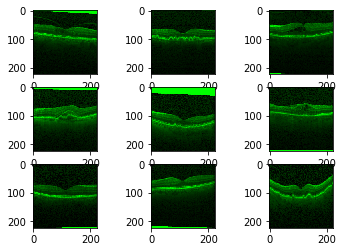

In [8]:
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_val2[i])
# show the plot
pyplot.show()

### CNV

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


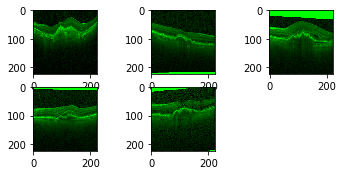

In [43]:
data1 = glob('eye/eye/val/CNV/**')
for i in range(0,5):
    q = load_image(data1[i])
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(q)
# show the plot
pyplot.show()

### DME

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


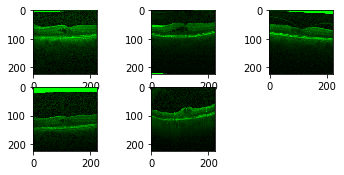

In [12]:
data1 = glob('eye/eye/val/DME/**')
for i in range(0,5):
    q = load_image(data1[i])
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(q)
# show the plot
pyplot.show()

### DRUSEN

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


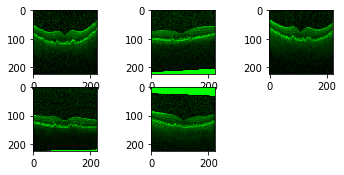

In [13]:
data1 = glob('eye/eye/val/DRUSEN/**')
for i in range(0,5):
    q = load_image(data1[i])
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(q)
# show the plot
pyplot.show()

## Normal

/home/ubuntu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


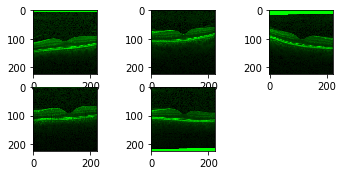

In [14]:
data1 = glob('eye/eye/val/NORMAL/**')
for i in range(0,5):
    q = load_image(data1[i])
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(q)
# show the plot
pyplot.show()

##  Data augmentation

The data given all ready had been augmented using flips and rotations, but not blurry or pixelated, so these data augmentations are for those cases. Each eye scan had multiple versions with different augmentations.  

In [36]:
def example_augment(img):
    augmented_img = np.fliplr(img)
    
    return augmented_img

**Augmentation Explanation:** This augmentation creates blurriness in the picture, so the numbers will be harder to read.

In [37]:
def augmentation_1(img):
    augmented_img = ndimage.gaussian_filter(img, sigma=2)
    
    return augmented_img

**Augmentation Explanation:** This adds noise to the picture like different color pixels randomly in the image.

In [38]:
def augmentation_2(img):
    
    # YOUR CODE GOES HERE
    im = ndimage.distance_transform_bf(img)
    augmented_img = im + 0.2 * np.random.randn(*im.shape)
    
    return augmented_img

Visualizing your augmentations.

In [45]:

sample_img = X_val2[7]
f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(sample_img)
axarr[0, 0].set_title('Original')
axarr[0, 1].imshow(example_augment(sample_img))
axarr[0, 1].set_title('Example Augment')
axarr[1, 0].imshow(augmentation_1(sample_img))
axarr[1, 0].set_title('Augmentation 1')
axarr[1, 1].imshow(augmentation_2(sample_img))
axarr[1, 1].set_title('Augmentation 2')

for ax in axarr.flat:
    ax.label_outer()
plt.show()


In [27]:
import random

def augment_data(data=X_train2, labels=y_train2, probability=0.33):
    X_augment = []
    y_augment = []
    for (img, label) in zip(data, labels):
        random_number = random.random()
        if (random_number > 2*probability):
            img_augment = example_augment(img)
        elif (random_number > probability and random_number <= 2 * probability):
            img_augment = augmentation_1(img)
        else:
            img_augment = augmentation_2(img)
        X_augment.append(img_augment)
        y_augment.append(label)

    X_augment = np.concatenate((data, X_augment), axis=0)
    y_augment = np.concatenate((labels, y_augment), axis=0)
    return X_augment, y_augment

## Section 2: Building the model

Here are 3 models to train the data. One is a basic Convolutional Neural Network model. One is VGG-16 model pretrained with imagenet. And the last is a VGG model without being pretrained.

In [50]:
model1 = Sequential()

model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', input_shape = (224, 224,3)))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Flatten())
model1.add(Dense(4, activation='softmax'))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 401412    
Total params: 421,668
Trainable params: 421,668
Non-trainable params: 0
_________________________________________________________________


In [51]:
from keras import optimizers
optimizer = optimizers.SGD(lr=0.01)
loss = 'categorical_crossentropy'

model1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [11]:
vgg = keras.applications.vgg16.VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
vgg2 = keras.applications.vgg16.VGG16(weights = None, include_top=False, input_shape=(224, 224, 3))

In [12]:
x = vgg.output

x = (Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', input_shape = (224,224,3))) (x)
x = (Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same'))(x)
x = (Dropout(0.25))(x)
x = (Flatten())(x)
predictions = (Dense(4, activation='softmax'))(x)

model2 = Model(inputs=vgg.input, outputs=predictions)

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
x = vgg2.output

x = (Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', input_shape = (224,224,3))) (x)
x = (Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same'))(x)
x = (Dropout(0.25))(x)
x = (Flatten())(x)
predictions = (Dense(4, activation='softmax'))(x)

model3 = Model(inputs=vgg2.input, outputs=predictions)

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
optimizer = 'adam'
loss = 'categorical_crossentropy'

model2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Section 3: Training the model

The code to train your model has been done for you already as it is a bit different than before due to the batch generator. Notice how we set `augment` to false for the validation generator. It is important never to augment your validation nor testing data since that can bias (inflate or deflate) the accuracy scores. The code also saves your models weights in the end which we can use for testing later on so we don't have to retrain it entirely.

In [15]:
# Uncomment for more Augments
#X_train, y_train = augment_data(data=X_train, labels=y_train, probability=0.33)

# Shuffle
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train2, y_train2, random_state=7)
X_test, y_test = shuffle(X_test2, y_test2, random_state=7)
X_val, y_val = shuffle(X_val2, y_val2, random_state=7)

print(X_val.shape)
print(X_test.shape)
print(X_train.shape)

(32, 224, 224, 3)
(968, 224, 224, 3)
(1000, 224, 224, 3)


In [52]:
history1 = model1.fit(X_train, y_train, batch_size = 30, epochs=30, verbose=1, validation_data=(X_val, y_val))

Train on 1000 samples, validate on 32 samples
Epoch 1/30
1000/1000 [==============================] - 49s 49ms/step - loss: 1.2477 - acc: 0.4010 - val_loss: 1.6465 - val_acc: 0.2500
Epoch 2/30
1000/1000 [==============================] - 49s 49ms/step - loss: 1.2037 - acc: 0.4710 - val_loss: 1.6903 - val_acc: 0.2500
Epoch 3/30
1000/1000 [==============================] - 49s 49ms/step - loss: 1.1904 - acc: 0.4660 - val_loss: 1.7235 - val_acc: 0.2500
Epoch 4/30
1000/1000 [==============================] - 49s 49ms/step - loss: 1.1659 - acc: 0.4870 - val_loss: 1.4512 - val_acc: 0.2813
Epoch 5/30
1000/1000 [==============================] - 49s 49ms/step - loss: 1.1540 - acc: 0.5070 - val_loss: 1.5797 - val_acc: 0.2500
Epoch 6/30
1000/1000 [==============================] - 49s 49ms/step - loss: 1.1269 - acc: 0.5180 - val_loss: 1.5175 - val_acc: 0.3438
Epoch 7/30
1000/1000 [==============================] - 49s 49ms/step - loss: 1.1014 - acc: 0.5520 - val_loss: 1.7646 - val_acc: 0.2500
Ep

In [18]:
history2 = model2.fit(X_train, y_train, batch_size = 30, epochs=3, verbose=1, validation_data=(X_val, y_val))

Train on 1000 samples, validate on 32 samples
Epoch 1/3
968/968 [==============================] - 789s 815ms/step - loss: 12.0719 - acc: 0.2510 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 2/3
968/968 [==============================] - 795s 822ms/step - loss: 12.0886 - acc: 0.2500 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 3/3
968/968 [==============================] - 796s 822ms/step - loss: 12.0886 - acc: 0.2500 - val_loss: 12.0886 - val_acc: 0.2500


In [26]:
history3 = model3.fit(X_train, y_train, batch_size = 30, epochs=3, verbose=1, validation_data=(X_val, y_val))

Train on 1000 samples, validate on 32 samples
Epoch 1/3
1000/1000 [==============================] - 822s 822ms/step - loss: 11.5889 - acc: 0.2810 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 2/3
1000/1000 [==============================] - 821s 821ms/step - loss: 11.4277 - acc: 0.2910 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 3/3
1000/1000 [==============================] - 822s 822ms/step - loss: 11.5244 - acc: 0.2850 - val_loss: 13.0960 - val_acc: 0.1875


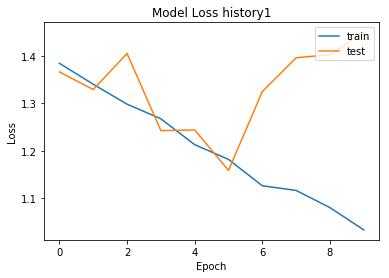

In [21]:
# Summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss history1')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

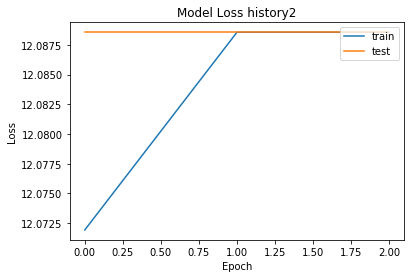

In [22]:
# Summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss history2')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

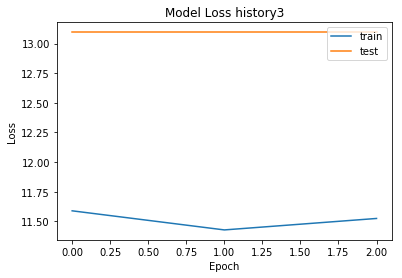

In [30]:
# Summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss history3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Section 4: Evaluation

In this section you will compute the accuracy of your model on the test data from Section 0. Make sure you very clearly have a cell that outputs and prints the percentage accuracy of your model. You will also include any code used to analyze the results here.

In [53]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred = model1.predict(X_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

accuracy = accuracy_score(y_test_class, y_pred_class)
print(accuracy)
print(classification_report(y_test_class,y_pred_class))
confusion_matrix(y_test_class, y_pred_class)

0.40289256198347106
             precision    recall  f1-score   support

          0       0.49      0.61      0.54       242
          1       0.37      0.24      0.29       242
          2       0.31      0.28      0.30       242
          3       0.40      0.48      0.44       242

avg / total       0.39      0.40      0.39       968



array([[148,  28,  33,  33],
       [ 73,  57,  42,  70],
       [ 62,  41,  68,  71],
       [ 21,  30,  74, 117]])

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred = model2.predict(X_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

accuracy = accuracy_score(y_test_class, y_pred_class)
print(accuracy)
print(classification_report(y_test_class,y_pred_class))
confusion_matrix(y_test_class, y_pred_class) 

0.106
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       441
          1       0.00      0.00      0.00       124
          2       0.11      1.00      0.19       106
          3       0.00      0.00      0.00       329

avg / total       0.01      0.11      0.02      1000



/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[  0,   0, 441,   0],
       [  0,   0, 124,   0],
       [  0,   0, 106,   0],
       [  0,   0, 329,   0]])

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred = model3.predict(X_test)
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

accuracy = accuracy_score(y_test_class, y_pred_class)
print(accuracy)
print(classification_report(y_test_class,y_pred_class))
confusion_matrix(y_test_class, y_pred_class)  

0.26239669421487605
             precision    recall  f1-score   support

          0       0.28      0.48      0.36       242
          1       0.00      0.00      0.00       242
          2       0.25      0.57      0.35       242
          3       0.00      0.00      0.00       242

avg / total       0.13      0.26      0.18       968



/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[115,   0, 127,   0],
       [114,   0, 128,   0],
       [103,   0, 139,   0],
       [ 73,   0, 169,   0]])

y_pred 1
y_true 1


<function matplotlib.pyplot.show(*args, **kw)>

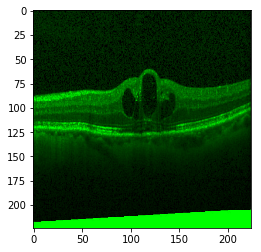

In [66]:
print('y_pred',np.argmax(y_pred[90]))
print('y_true',np.argmax(y_test[90]))
pyplot.imshow(X_test[90])
pyplot.show

\* Project Code inspired and taken from Udacity's AI Nanodegress https://github.com/mahavird/dog-project. All credit for the helper methods to load the dataset goes to Udacity.
Code adapted from code by Sujith Vishwajith
